# TODO: Title
**TODO**: Give a helpful introduction to what this notebook is for. Remember that comments, explanations and good documentation make your project informative and professional.

**Note:** This notebook has a bunch of code and markdown cells with TODOs that you have to complete. These are meant to be helpful guidelines for you to finish your project while meeting the requirements in the project rubrics. Feel free to change the order of the TODO's and/or use more than one cell to complete all the tasks.

In [9]:
# TODO: Install any packages that you might need
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

import requests
import os
import json
import boto3
import sagemaker
from sagemaker.pytorch import PyTorch
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)
from sagemaker.pytorch import PyTorchModel
from sagemaker.serializers import IdentitySerializer
from PIL import Image
from IPython.display import Image as ImageDisplay
import io
from tqdm import tqdm





In [10]:
from os import listdir
from os.path import isfile, join
from collections import defaultdict
from sagemaker.predictor import Predictor

In [11]:
# TODO: Import any packages that you might need
session = sagemaker.Session()
bucket= session.default_bucket()
print("Bucket Name: {}".format(bucket))
region = session.boto_region_name
print("AWS Region: {}".format(region))
role = sagemaker.get_execution_role()
print("Role Name: {}".format(role))

Bucket Name: sagemaker-us-east-1-130662402521
AWS Region: us-east-1
Role Name: arn:aws:iam::130662402521:role/service-role/AmazonSageMaker-ExecutionRole-20221018T123587


## Data Preparation
**TODO:** Run the cell below to download the data.

The cell below creates a folder called `train_data`, downloads training data and arranges it in subfolders. Each of these subfolders contain images where the number of objects is equal to the name of the folder. For instance, all images in folder `1` has images with 1 object in them. Images are not divided into training, testing or validation sets. If you feel like the number of samples are not enough, you can always download more data (instructions for that can be found [here](https://registry.opendata.aws/amazon-bin-imagery/)). However, we are not acessing you on the accuracy of your final trained model, but how you create your machine learning engineering pipeline.

In [ ]:
'''train_data =  'train_data'

def download_and_arrange_data(train_data):
    s3_client = boto3.client('s3')

    with open('file_list.json', 'r') as f:
        d=json.load(f)

    for k, v in d.items():
        print(f"Downloading Images with {k} objects")
        directory=os.path.join(train_data, k)
        if not os.path.exists(directory):
            os.makedirs(directory)
        for file_path in tqdm(v):
            file_name=os.path.basename(file_path).split('.')[0]+'.jpg'
            s3_client.download_file('aft-vbi-pds', os.path.join('bin-images', file_name),
                             os.path.join(directory, file_name))

download_and_arrange_data(train_data)
'''

/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages/boto3/compat.py:88: PythonDeprecationWarning: Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
  warnings.warn(warning, PythonDeprecationWarning)


100%|██████████| 1228/1228 [01:53<00:00, 10.79it/s]


100%|██████████| 2299/2299 [03:32<00:00, 10.79it/s]


 64%|██████▍   | 1702/2666 [02:34<01:46,  9.04it/s]

## Dataset
**TODO:** Explain what dataset you are using for this project. Give a small overview of the classes, class distributions etc that can help anyone not familiar with the dataset get a better understanding of it. You can find more information about the data [here](https://registry.opendata.aws/amazon-bin-imagery/).

In [8]:
#TODO: Perform any data cleaning or data preprocessing
train_data = "train_data"
main_dirs = os.listdir(train_data)
main_dirs.sort()
num_items = {}
file_lists = {}
for directory in main_dirs:
    file_lists[directory] = [s for s in os.listdir(os.path.join(train_data, directory)) if "jpg" in s]
    file_lists[directory].sort()
    num_items[directory] = len(file_lists[directory])
    print(f'Number of images are {num_items[directory]} images with {directory} items in it.')

Number of images are 1228 images with 1 items in it.
Number of images are 2299 images with 2 items in it.
Number of images are 2666 images with 3 items in it.
Number of images are 2373 images with 4 items in it.
Number of images are 1875 images with 5 items in it.


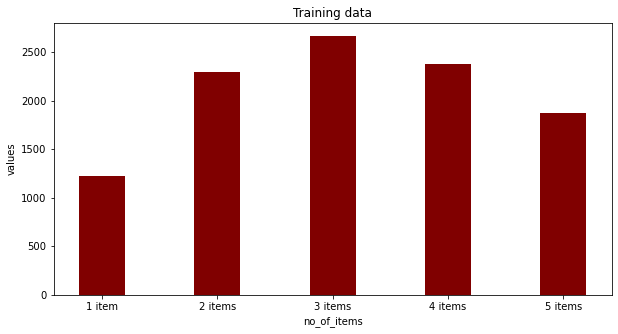

In [7]:

data = {'1 item':1228, '2 items':2299, '3 items':2666,
        '4 items':2373,'5 items':1875}
no_of_items = list(data.keys())
values = list(data.values())
  
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(no_of_items, values, color ='maroon',
        width = 0.4)
 
plt.xlabel("no_of_items")
plt.ylabel("values")
plt.title("Training data")
plt.show()

In [7]:

train_data = "train_data"


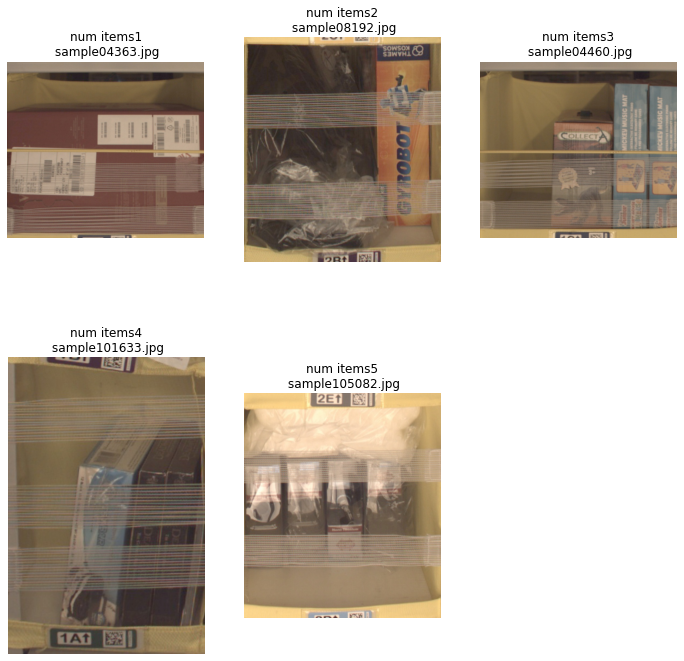

In [12]:
# Plot some of the data
figure = plt.figure(figsize=(12, 12))
cols, rows = 3, 2
for key in num_items.keys():
    sample_idx = random.randint(0, num_items[key]-1)
    img_filename = file_lists[key][sample_idx]
    label = "num items" +key + "\n sample"+ img_filename
    figure.add_subplot(rows, cols, int(key))
    plt.title(label)
    plt.axis("off")
    plt.imshow(mpimg.imread(os.path.join(train_data, key, img_filename)).squeeze(), cmap="gray")
plt.show()

In [14]:
file_list_train = {}
file_list_test = {}
for key in num_items.keys():
    test_no = int(0.2*num_items[key])
    train_no =  int(num_items[key] - test_no)
    file_list_test[key] = []
    file_list_train[key] = []
    for idx, filename in enumerate(file_lists[key]):
        if (idx<(test_no)):
            file_list_test[key].append(filename)
        else:
            file_list_train[key].append(filename)
            
    print(f'num items {key}: Test: {test_no}, Train: {train_no}')

num items 1: Test: 245, Train: 983
num items 2: Test: 459, Train: 1840
num items 3: Test: 533, Train: 2133
num items 4: Test: 474, Train: 1899
num items 5: Test: 375, Train: 1500


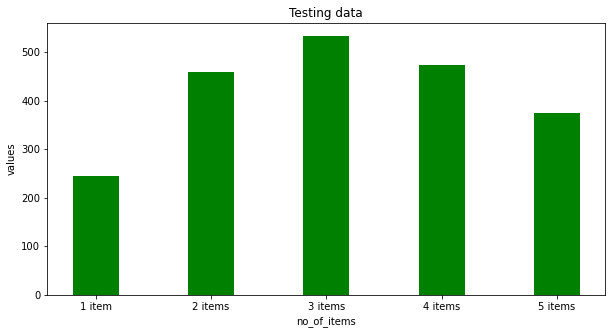

In [17]:

data = {'1 item':245, '2 items':459, '3 items':533,
        '4 items':474,'5 items':375}
no_of_items = list(data.keys())
values = list(data.values())
  
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(no_of_items, values, color ='green',
        width = 0.4)
 
plt.xlabel("no_of_items")
plt.ylabel("values")
plt.title("Testing data")
plt.show()

In [7]:
'''new_path =  "new_data"
os.mkdir(new_path)
os.mkdir(os.path.join(new_path, 'test'))
os.mkdir(os.path.join(new_path, 'train'))
for key in num_items.keys():
    os.mkdir(os.path.join(new_path, 'test', key))
    os.mkdir(os.path.join(new_path, 'train', key))
'''

FileExistsError: [Errno 17] File exists: 'new_data'

In [18]:
#TODO: Upload the data to AWS S3
#!aws s3 cp new_data s3://sagemaker-us-east-1-130662402521/new_data --recursive

upload: new_data/test/1/00009.jpg to s3://sagemaker-us-east-1-130662402521/new_data/test/1/00009.jpg
upload: new_data/test/1/00048.jpg to s3://sagemaker-us-east-1-130662402521/new_data/test/1/00048.jpg
upload: new_data/test/1/00086.jpg to s3://sagemaker-us-east-1-130662402521/new_data/test/1/00086.jpg
upload: new_data/test/1/00035.jpg to s3://sagemaker-us-east-1-130662402521/new_data/test/1/00035.jpg
upload: new_data/test/1/00152.jpg to s3://sagemaker-us-east-1-130662402521/new_data/test/1/00152.jpg
upload: new_data/test/1/00014.jpg to s3://sagemaker-us-east-1-130662402521/new_data/test/1/00014.jpg
upload: new_data/test/1/00024.jpg to s3://sagemaker-us-east-1-130662402521/new_data/test/1/00024.jpg
upload: new_data/test/1/00148.jpg to s3://sagemaker-us-east-1-130662402521/new_data/test/1/00148.jpg
upload: new_data/test/1/00214.jpg to s3://sagemaker-us-east-1-130662402521/new_data/test/1/00214.jpg
upload: new_data/test/1/00284.jpg to s3://sagemaker-us-east-1-130662402521/new_data/test/1/

## Model Training
**TODO:** This is the part where you can train a model. The type or architecture of the model you use is not important. 

**Note:** You will need to use the `train.py` script to train your model.

In [10]:
#TODO: Declare your model training hyperparameter.
#NOTE: You do not need to do hyperparameter tuning. You can use fixed hyperparameter values
hyperparameters = {
    "batch-size": "256",
    "epochs": 4,
    "lr": "0.01",
}

In [40]:
#TODO: Create your training estimator
estimator = PyTorch(
    role=role,
    instance_count=1,
    instance_type="ml.m5.2xlarge",
    source_dir=".",
    entry_point="train.py",
    framework_version="1.8",
    py_version="py36",
    hyperparameters=hyperparameters,
)

In [12]:
train_path = "s3://sagemaker-us-east-1-130662402521/new_data/train" 
test_path = "s3://sagemaker-us-east-1-130662402521/new_data/test"

In [27]:
# TODO: Fit your estimator
estimator.fit({"train": train_path, "test": test_path})

2022-11-08 20:42:33 Starting - Starting the training job...
2022-11-08 20:42:59 Starting - Preparing the instances for trainingProfilerReport-1667940152: InProgress
......
2022-11-08 20:43:59 Downloading - Downloading input data......
2022-11-08 20:44:59 Training - Downloading the training image...
2022-11-08 20:45:25 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-11-08 20:45:27,688 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2022-11-08 20:45:27,691 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2022-11-08 20:45:27,700 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2022-11-08 20:45:27,707 sagemaker_pytorch_container.training INFO     Invoking user training script.
2022-11-08 20:45:47,327 sagemaker-training-toolkit INFO     No GP

## Standout Suggestions
You do not need to perform the tasks below to finish your project. However, you can attempt these tasks to turn your project into a more advanced portfolio piece.

### Hyperparameter Tuning
**TODO:** Here you can perform hyperparameter tuning to increase the performance of your model. You are encouraged to 
- tune as many hyperparameters as you can to get the best performance from your model
- explain why you chose to tune those particular hyperparameters and the ranges.


In [41]:
#TODO: Create your hyperparameter search space
hyperparameter_ranges = {
    "lr": ContinuousParameter(0.005, 0.1),
    "batch-size": CategoricalParameter([16, 32, 64]),
    "epochs": IntegerParameter(4, 8)
}

In [42]:
objective_type = "Minimize"
objective_metric_name = "average test accuracy"
metric_definitions = [{"Name": "average test accuracy", "Regex": "Testing Loss: ([0-9\\.]+)"}]

In [43]:
tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=5,
    max_parallel_jobs=5,
    objective_type=objective_type,
)

In [ ]:
tuner.fit({"train": train_path, "test": test_path})